#### To use the Random Forest Survival analysis you will need to use the Pysurvival package.
To install this package please follow the instructions from this site https://square.github.io/pysurvival/installation.html
##### For MacOS users:
You will need to add two more lines besides the recommended 2 as shown below:
###### Note: please check which version of gcc do you have as it might be different from 9.3.0.



### To use the Random Forest Survival analysis we need to load the data and remove the colinear features

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
sns.set()
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

### using the panda reader import your file where the data is contained

In [2]:
clinical_data=pd.read_excel('WithoutMRNEndometrial_TextureFeatures_09182019.xlsx')
other_data=pd.read_excel('1.20.20 DeIdentified_HG_CT_JJM_AS_Clinical Variables_Final.xlsx')

other_data.columns

Index(['De-Identified Study ID', 'ExamStatus', 'Tumor Visible', 'CT_Make',
       'CT_ST', 'CT_kVp', 'CT_mA', 'CT_Pitch', 'Age at Dx', 'Race',
       'BMI-Category', 'Diabetes (y/n)', 'Histology', 'Final Grade',
       'Fundal/Extrafundal', 'Node Status (+/-)', 'Adjuvant treatment (y/n)',
       'Chemo (y/n)', 'RT (y/n)', 'Recurrence (y/n)', 'Date of Recurrence',
       'Time to Recurrence (months)',
       'Pt recurred prior to 18 months (0=no 1= yes)', 'Deceased (y/n)',
       'Overall Survival (Months)', 'Reason for excluxion', 'Comments',
       'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30'],
      dtype='object')

In [3]:
other_data.columns


Index(['De-Identified Study ID', 'ExamStatus', 'Tumor Visible', 'CT_Make',
       'CT_ST', 'CT_kVp', 'CT_mA', 'CT_Pitch', 'Age at Dx', 'Race',
       'BMI-Category', 'Diabetes (y/n)', 'Histology', 'Final Grade',
       'Fundal/Extrafundal', 'Node Status (+/-)', 'Adjuvant treatment (y/n)',
       'Chemo (y/n)', 'RT (y/n)', 'Recurrence (y/n)', 'Date of Recurrence',
       'Time to Recurrence (months)',
       'Pt recurred prior to 18 months (0=no 1= yes)', 'Deceased (y/n)',
       'Overall Survival (Months)', 'Reason for excluxion', 'Comments',
       'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30'],
      dtype='object')

In [4]:
# in this data sets certain rows are excluded so we have to remove them 
raddata=clinical_data.drop([4, 7, 11, 13, 23, 25, 29, 36, 41, 47, 61, 62, 63, 68, 76, 88, 94, 96, 
                          108, 133, 135, 142]).reset_index(drop=True)
o_data=other_data.drop([4,7, 11, 13, 23, 25, 29, 36, 41, 47, 61, 62, 63, 68, 76, 88, 94, 96, 
                          108, 133, 135, 142]).reset_index(drop=True)
o_data
raddata.columns
coo=pd.DataFrame()
raddata2=raddata.drop(columns=['De identified Study ID'])
raddata2

,GLCM1,GLCM2,GLCM3,GLCM4,GLCM5,GLCM6,GLCM7,GLCM8,GLCM9,GLCM10,...,ACM2_10,ACM2_11,ACM2_12,ACM2_13,ACM2_14,ACM2_15,ACM2_16,ACM2_17,ACM2_18,ACM2_19
0,0.026256,4.333412,0.449950,3.917603,0.454955,18.285737,11.337002,3.752016,5.716646,1.820537,...,8.721173,2.940614,-0.148826,0.818354,0.593029,15.073033,1589.851794,25079.738554,4.739398,0.986655
1,0.050280,2.314190,0.484697,2.424970,0.537827,17.646685,7.385692,3.347634,4.862031,0.980414,...,13.201337,3.010564,-0.199530,0.884071,0.685592,22.045709,1375.243100,22262.287867,4.737088,0.986307
2,0.023361,5.228412,0.398057,4.528518,0.411689,14.291180,12.885660,3.826931,5.966786,2.091924,...,15.510645,3.415731,-0.087748,0.692718,0.457665,29.858372,1154.498568,18661.617962,5.744309,0.992419
3,0.039554,1.855517,0.711033,3.394799,0.580393,17.935818,11.723678,3.712137,5.129299,0.836158,...,10.880541,2.965569,-0.170623,0.851561,0.672977,17.817663,1262.648674,20244.421621,4.899353,0.986331
4,0.047469,1.912943,0.601263,2.375858,0.567263,22.745457,7.590489,3.470541,4.902669,0.831977,...,10.105123,3.008932,-0.154445,0.826874,0.615075,17.461522,1611.613851,26946.037976,4.589336,0.984273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,0.030961,3.329703,0.451058,3.087595,0.476773,18.400621,9.020677,3.600778,5.457496,1.359409,...,13.744894,3.237901,-0.117999,0.762980,0.544010,24.375379,1216.030259,19845.283280,5.463958,0.990320
131,0.029211,3.481393,0.501623,3.940367,0.474784,12.609427,12.280073,3.721832,5.599860,1.440576,...,12.915139,3.192640,-0.128645,0.762071,0.644287,22.532088,1229.523023,18864.092413,2.946259,0.955650
132,0.035093,2.847245,0.527364,3.044318,0.511396,16.492182,9.330027,3.623143,5.368373,1.229950,...,17.301398,3.374493,-0.104464,0.734452,0.527287,31.631916,1131.817162,19269.673532,5.463295,0.991081
133,0.033468,1.997960,0.713680,3.649665,0.556493,16.244867,12.600701,3.835563,5.356900,0.856659,...,15.174270,3.351991,-0.091512,0.711624,0.492463,27.887957,1324.578843,21823.254109,5.910660,0.992627


#### Isolating the clinical variables which will be needed for the Random Forest

In [5]:
coo['time column']=o_data['Time to Recurrence (months)']
coo['event column']=o_data['Recurrence (y/n)']
coo['age']=o_data['Age at Dx']
coo['adjuvalent']=o_data['Adjuvant treatment (y/n)']
coo['Chemo ']=o_data['Chemo (y/n)']
coo['Diabetes']=o_data['Diabetes (y/n)']
coo['Node Status']=o_data['Node Status (+/-)']


In [6]:
coo.columns
coo

,time column,event column,age,adjuvalent,Chemo,Diabetes,Node Status
0,72.866667,0.0,69,1.0,1.0,0.0,0.0
1,57.733333,0.0,71,1.0,1.0,0.0,0.0
2,69.100000,0.0,55,1.0,1.0,0.0,0.0
3,39.233333,0.0,61,1.0,1.0,0.0,0.0
4,20.000000,1.0,63,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
130,22.400000,0.0,64,1.0,1.0,0.0,0.0
131,8.266667,1.0,73,1.0,0.0,1.0,0.0
132,18.666667,0.0,70,1.0,0.0,0.0,0.0
133,20.300000,0.0,68,1.0,1.0,1.0,0.0


#### some variables need to be dummified because their assigned numerical values are of categorical type.

In [7]:
#here we use get_dummies to create dummy variables 
test=o_data.loc[:,['Race', 'BMI-Category', 'Histology']]
test2=pd.get_dummies(test['Race'], prefix='race')

test3=pd.get_dummies(test['BMI-Category'], prefix ='BMI')
test4=pd.get_dummies(test['Histology'], prefix='Hist')
new_test=pd.concat([test2, test3, test4], axis=1)
new_test

,race_0.0,race_1.0,race_2.0,race_3.0,race_4.0,BMI_0.0,BMI_1.0,BMI_2.0,Hist_0,Hist_1,Hist_2,Hist_3,Hist_4
0,0,1,0,0,0,0,1,0,0,1,0,0,0
1,0,0,1,0,0,1,0,0,1,0,0,0,0
2,1,0,0,0,0,0,1,0,1,0,0,0,0
3,1,0,0,0,0,1,0,0,1,0,0,0,0
4,0,0,0,0,1,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,1,0,0,0,0,0,1,0,0,1,0,0,0
131,0,0,1,0,0,1,0,0,0,0,1,0,0
132,0,0,1,0,0,1,0,0,1,0,0,0,0
133,1,0,0,0,0,0,1,0,0,0,1,0,0


In [8]:
#these radiomic variables were filtered based on the previous results
data2=raddata.loc[:, ['LBP94', 'LBP101', 'LBP106', 'LBP107', 'LBP108', 'LBP112', 'LBP116',
       'LBP118', 'LBP119', 'LBP120', 'FD27', 'FD51', 'FD54', 'ACM1_12']]

In [9]:
data = pd.concat([data2, coo, new_test], axis=1)
data

,LBP94,LBP101,LBP106,LBP107,LBP108,LBP112,LBP116,LBP118,LBP119,LBP120,...,race_3.0,race_4.0,BMI_0.0,BMI_1.0,BMI_2.0,Hist_0,Hist_1,Hist_2,Hist_3,Hist_4
0,0.008640,0.013356,0.004859,0.004859,0.004132,0.000000,0.010616,0.007653,0.002066,0.000000,...,0,0,0,1,0,0,1,0,0,0
1,0.007668,0.048193,0.000000,0.004474,0.002237,0.002237,0.022017,0.025663,0.002237,0.002268,...,0,0,1,0,0,1,0,0,0,0
2,0.021092,0.012521,0.004832,0.004832,0.002381,0.002381,0.010747,0.013208,0.000456,0.000000,...,0,0,0,1,0,1,0,0,0,0
3,0.016198,0.010369,0.000418,0.000418,0.002021,0.001185,0.009453,0.017735,0.000000,0.001094,...,0,0,1,0,0,1,0,0,0,0
4,0.009955,0.005240,0.002404,0.002404,0.000000,0.000000,0.014629,0.011696,0.004484,0.000000,...,0,1,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,0.022039,0.010716,0.003116,0.003159,0.003084,0.002702,0.008869,0.014814,0.000392,0.000713,...,0,0,0,1,0,0,1,0,0,0
131,0.012268,0.011711,0.001980,0.002713,0.001017,0.000758,0.006853,0.014726,0.001896,0.000630,...,0,0,1,0,0,0,0,1,0,0
132,0.015814,0.010354,0.001611,0.003510,0.000773,0.000773,0.008804,0.009672,0.002337,0.000396,...,0,0,1,0,0,1,0,0,0,0
133,0.019432,0.016423,0.002315,0.002550,0.001315,0.000583,0.009172,0.014753,0.000963,0.000259,...,0,0,0,1,0,0,0,1,0,0


In [34]:
#the complete dataset with filtered radiomic and clinical data
data

,LBP94,LBP101,LBP106,LBP107,LBP108,LBP112,LBP116,LBP118,LBP119,LBP120,...,race_3.0,race_4.0,BMI_0.0,BMI_1.0,BMI_2.0,Hist_0,Hist_1,Hist_2,Hist_3,Hist_4
0,0.008640,0.013356,0.004859,0.004859,0.004132,0.000000,0.010616,0.007653,0.002066,0.000000,...,0,0,0,1,0,0,1,0,0,0
1,0.007668,0.048193,0.000000,0.004474,0.002237,0.002237,0.022017,0.025663,0.002237,0.002268,...,0,0,1,0,0,1,0,0,0,0
2,0.021092,0.012521,0.004832,0.004832,0.002381,0.002381,0.010747,0.013208,0.000456,0.000000,...,0,0,0,1,0,1,0,0,0,0
3,0.016198,0.010369,0.000418,0.000418,0.002021,0.001185,0.009453,0.017735,0.000000,0.001094,...,0,0,1,0,0,1,0,0,0,0
4,0.009955,0.005240,0.002404,0.002404,0.000000,0.000000,0.014629,0.011696,0.004484,0.000000,...,0,1,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,0.022039,0.010716,0.003116,0.003159,0.003084,0.002702,0.008869,0.014814,0.000392,0.000713,...,0,0,0,1,0,0,1,0,0,0
131,0.012268,0.011711,0.001980,0.002713,0.001017,0.000758,0.006853,0.014726,0.001896,0.000630,...,0,0,1,0,0,0,0,1,0,0
132,0.015814,0.010354,0.001611,0.003510,0.000773,0.000773,0.008804,0.009672,0.002337,0.000396,...,0,0,1,0,0,1,0,0,0,0
133,0.019432,0.016423,0.002315,0.002550,0.001315,0.000583,0.009172,0.014753,0.000963,0.000259,...,0,0,0,1,0,0,0,1,0,0


In [11]:
time_column='time column'
event_column='event column'
features=np.setdiff1d(data.columns, [time_column, event_column]).tolist()
len(features)
features
data2=data[features]
data2.isna().sum()
data3=data2.fillna(0)
data3

,ACM1_12,BMI_0.0,BMI_1.0,BMI_2.0,Chemo,Diabetes,FD27,FD51,FD54,Hist_0,...,LBP120,LBP94,Node Status,adjuvalent,age,race_0.0,race_1.0,race_2.0,race_3.0,race_4.0
0,-0.072218,0,1,0,1.0,0.0,9.000000,0.079923,0.068974,0,...,0.000000,0.008640,0.0,1.0,69,0,1,0,0,0
1,-0.128768,1,0,0,1.0,0.0,3.333333,0.128958,0.112149,1,...,0.002268,0.007668,0.0,1.0,71,0,0,1,0,0
2,-0.044774,0,1,0,1.0,0.0,15.250000,0.056418,0.044223,1,...,0.000000,0.021092,0.0,1.0,55,1,0,0,0,0
3,-0.076017,1,0,0,1.0,0.0,15.750000,0.141440,0.121297,1,...,0.001094,0.016198,0.0,1.0,61,1,0,0,0,0
4,-0.071011,0,1,0,0.0,0.0,8.000000,0.157050,0.145854,0,...,0.000000,0.009955,0.0,1.0,63,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,-0.051001,0,1,0,1.0,0.0,24.500000,0.087100,0.067616,0,...,0.000713,0.022039,0.0,1.0,64,1,0,0,0,0
131,-0.155972,1,0,0,0.0,1.0,25.888889,0.055196,0.037529,0,...,0.000630,0.012268,0.0,1.0,73,0,0,1,0,0
132,-0.041698,1,0,0,0.0,0.0,31.714286,0.100156,0.067450,1,...,0.000396,0.015814,0.0,1.0,70,0,0,1,0,0
133,-0.032100,0,1,0,1.0,1.0,59.888889,0.112976,0.065836,0,...,0.000259,0.019432,0.0,1.0,68,1,0,0,0,0


In [12]:
data3.columns

Index(['ACM1_12', 'BMI_0.0', 'BMI_1.0', 'BMI_2.0', 'Chemo ', 'Diabetes',
       'FD27', 'FD51', 'FD54', 'Hist_0', 'Hist_1', 'Hist_2', 'Hist_3',
       'Hist_4', 'LBP101', 'LBP106', 'LBP107', 'LBP108', 'LBP112', 'LBP116',
       'LBP118', 'LBP119', 'LBP120', 'LBP94', 'Node Status', 'adjuvalent',
       'age', 'race_0.0', 'race_1.0', 'race_2.0', 'race_3.0', 'race_4.0'],
      dtype='object')

### We will be using Variance Inflation Factor to remove the colinear features
In the RFS analysis it is very important to remove the colinear features

In [13]:
#creating a new dataframe with colinear features removed
fil_data=data.loc[:, ['ACM1_12', 'BMI_0.0', 'BMI_1.0', 'BMI_2.0', 'Chemo ', 'Diabetes',
       'FD27', 'FD51', 'FD54', 'Hist_0', 'Hist_1', 'Hist_2', 'Hist_3',
       'Hist_4', 'LBP101', 'LBP106', 'LBP107', 'LBP108', 'LBP112', 'LBP116',
       'LBP118', 'LBP119', 'LBP120', 'LBP94', 'Node Status', 'adjuvalent',
       'age', 'race_0.0', 'race_1.0', 'race_2.0', 'race_3.0', 'race_4.0', 'time column', 'event column']]
fil_data.isnull().sum()
fil_data=fil_data.fillna(0)
fil_data.isnull().sum()

ACM1_12         0
BMI_0.0         0
BMI_1.0         0
BMI_2.0         0
Chemo           0
Diabetes        0
FD27            0
FD51            0
FD54            0
Hist_0          0
Hist_1          0
Hist_2          0
Hist_3          0
Hist_4          0
LBP101          0
LBP106          0
LBP107          0
LBP108          0
LBP112          0
LBP116          0
LBP118          0
LBP119          0
LBP120          0
LBP94           0
Node Status     0
adjuvalent      0
age             0
race_0.0        0
race_1.0        0
race_2.0        0
race_3.0        0
race_4.0        0
time column     0
event column    0
dtype: int64

In [14]:
#create a dataframe with time and event columns
time_column='time column'
event_column='event column'
features2=np.setdiff1d(fil_data.columns, [time_column, event_column]).tolist()
len(features)
features2

['ACM1_12',
 'BMI_0.0',
 'BMI_1.0',
 'BMI_2.0',
 'Chemo ',
 'Diabetes',
 'FD27',
 'FD51',
 'FD54',
 'Hist_0',
 'Hist_1',
 'Hist_2',
 'Hist_3',
 'Hist_4',
 'LBP101',
 'LBP106',
 'LBP107',
 'LBP108',
 'LBP112',
 'LBP116',
 'LBP118',
 'LBP119',
 'LBP120',
 'LBP94',
 'Node Status',
 'adjuvalent',
 'age',
 'race_0.0',
 'race_1.0',
 'race_2.0',
 'race_3.0',
 'race_4.0']

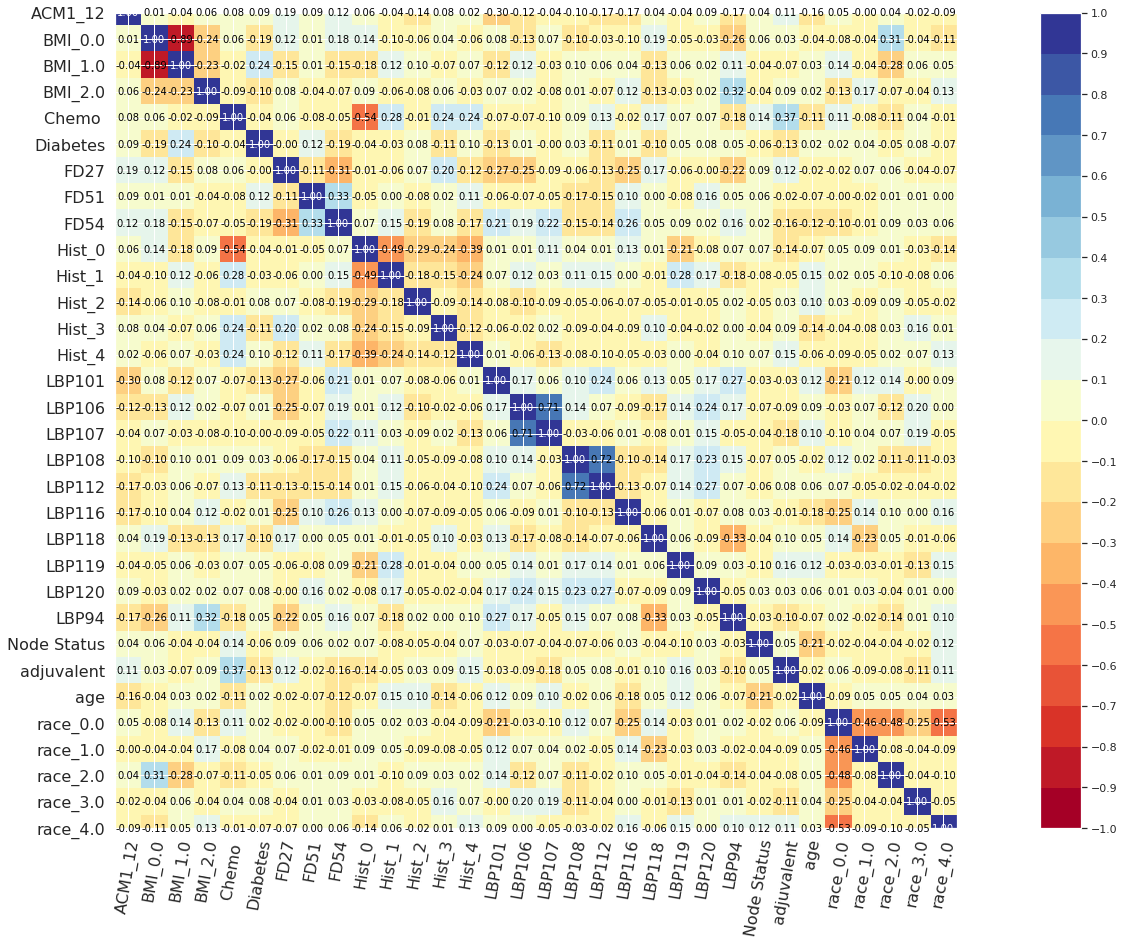

In [28]:
#visualize the correlation matrix
from pysurvival.utils.display import correlation_matrix
correlation_matrix(fil_data[features2], figure_size=(30,15), text_fontsize=10)

#### Now we are ready to analyze our data 
 we need to define our input (X), time (T) and event (E) columns


In [15]:
# Creating the X, T and E inputs


newX=np.setdiff1d(fil_data.columns, [ event_column]).tolist()
X=fil_data[newX]
E=fil_data['event column']
X
E

0      0.0
1      0.0
2      0.0
3      0.0
4      1.0
      ... 
130    0.0
131    1.0
132    0.0
133    0.0
134    0.0
Name: event column, Length: 135, dtype: float64

### Now we are ready to perform the random forest survival analysis
#### In this example we are using the 5 Stratified Kfold and and evaluating the performance of each run by 
#### evaluating the concordance and plotting the predicted survival curve and error
###### xst1 is the model using only the radiomic features
###### xst2 is the model using only the clinical data 
###### xst3 is the model using all the available data 


 1 of kfold 5
C-index: 0.69


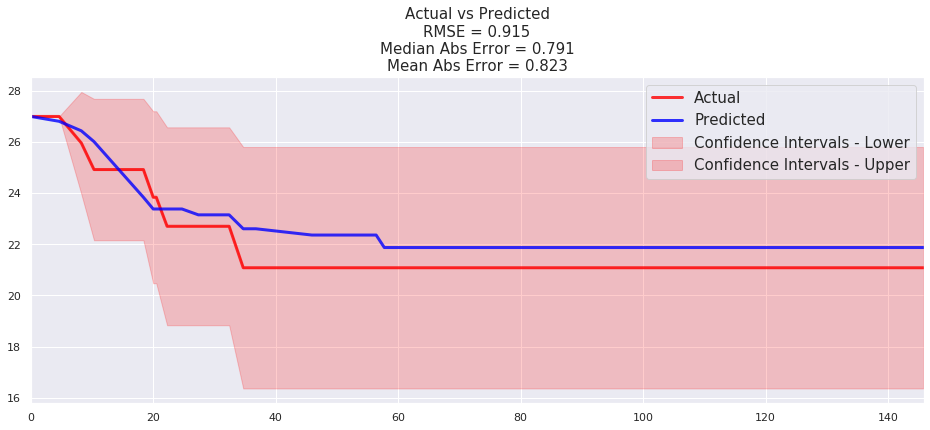

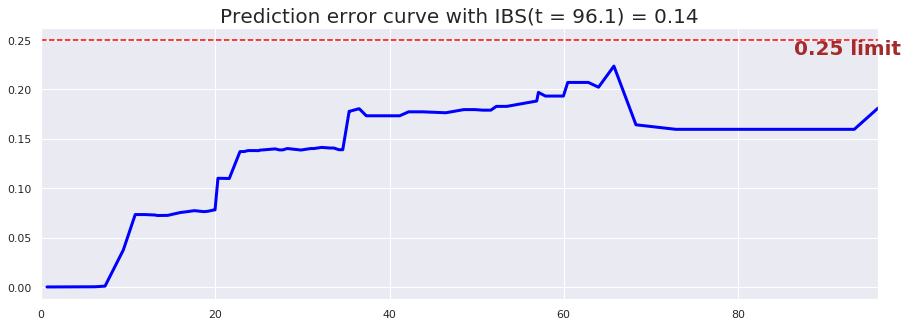

IBS: 0.14

 1 of kfold 5
xst2 2 C-index: 0.56


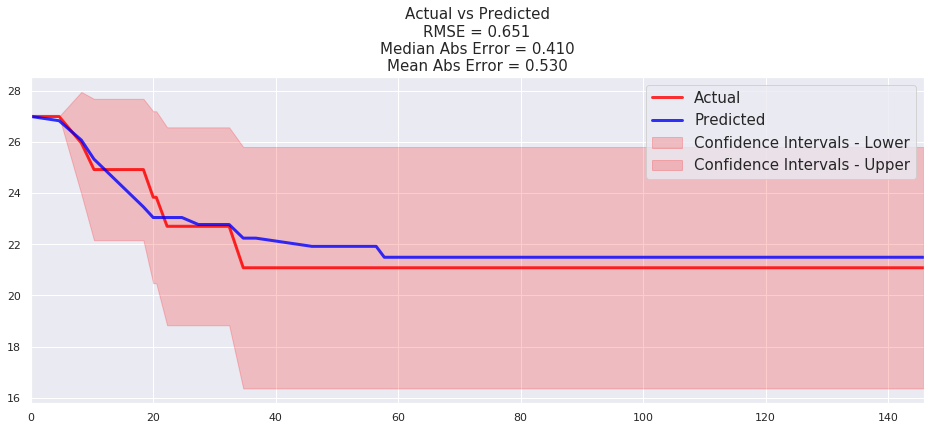

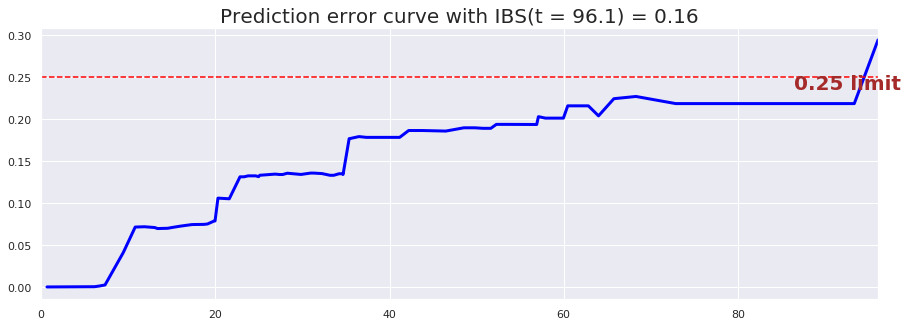

IBS: 0.16

 1 of kfold 5
xst3 3 C-index: 0.72


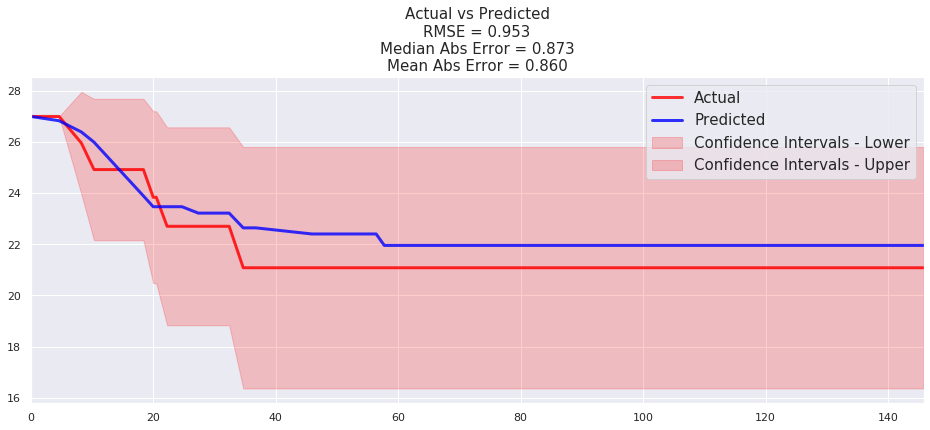

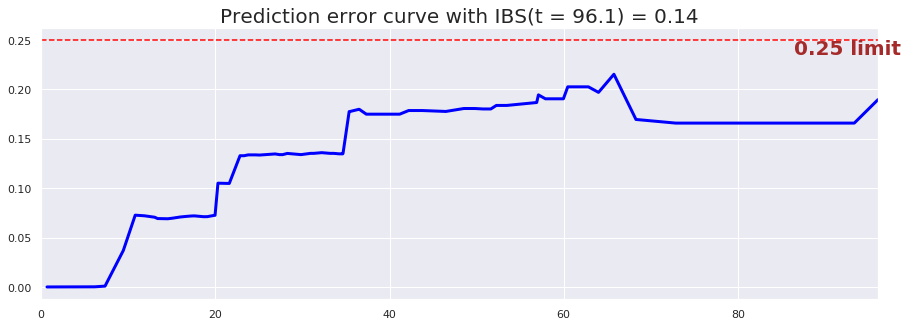

IBS: 0.14

 2 of kfold 5
C-index: 0.68


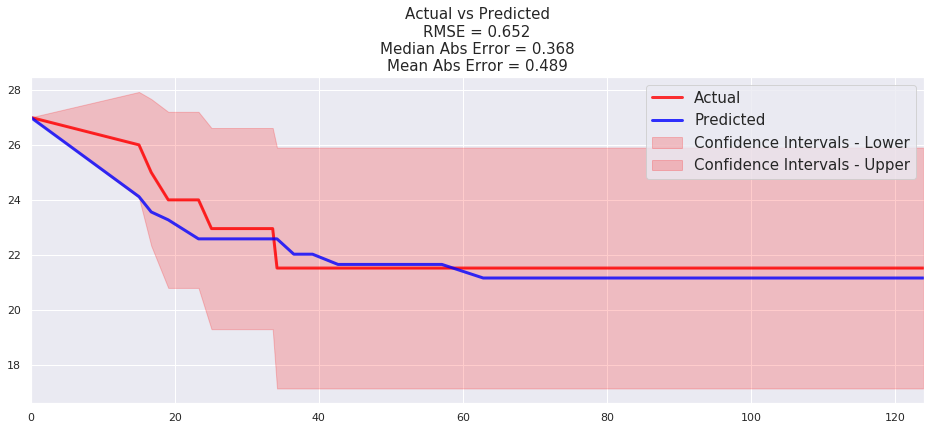

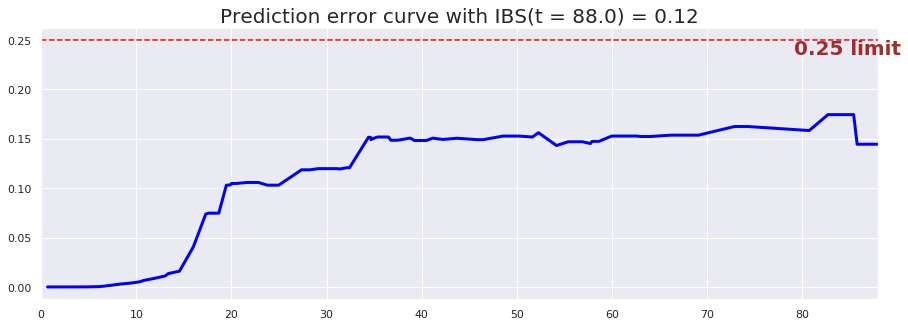

IBS: 0.12

 2 of kfold 5
xst2 2 C-index: 0.60


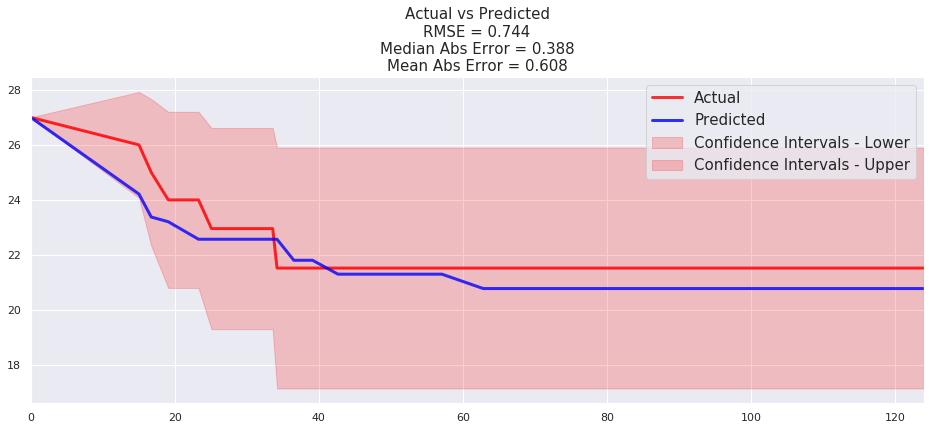

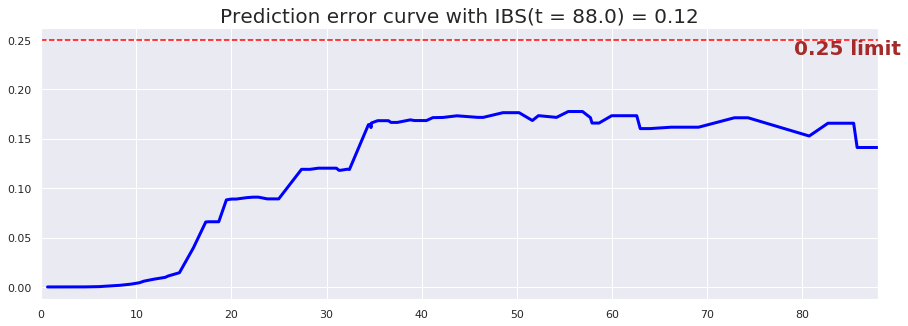

IBS: 0.12

 2 of kfold 5
xst3 3 C-index: 0.77


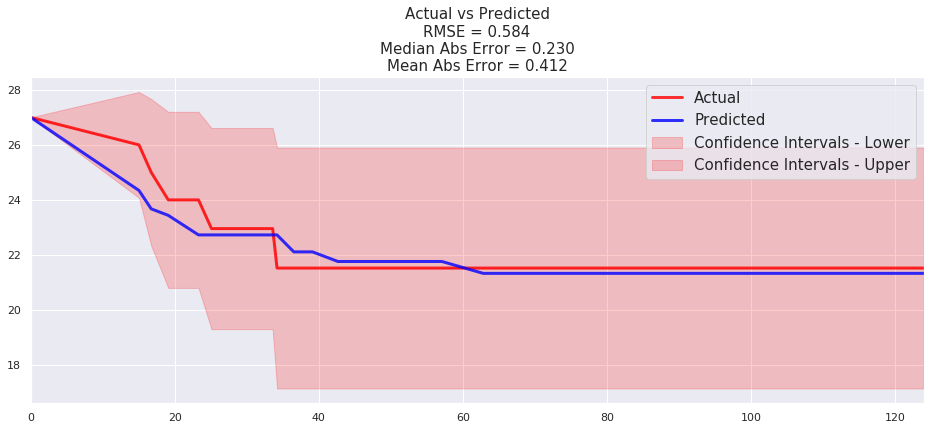

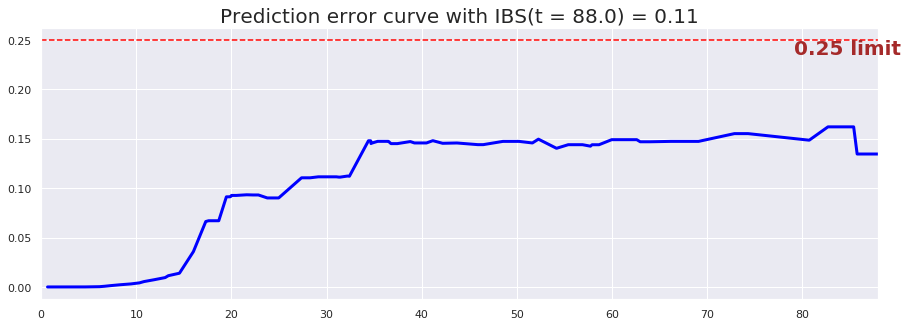

IBS: 0.11

 3 of kfold 5
C-index: 0.66


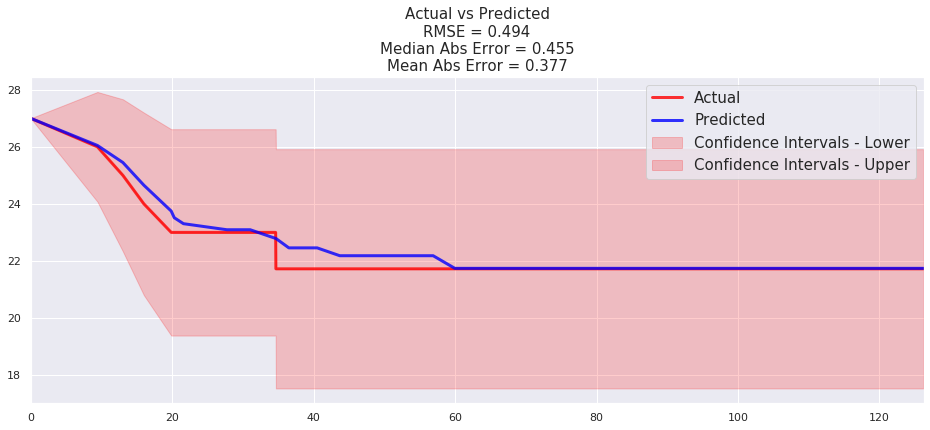

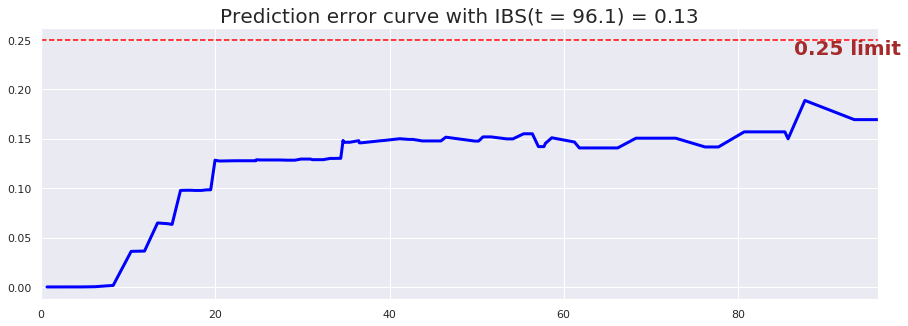

IBS: 0.13

 3 of kfold 5
xst2 2 C-index: 0.68


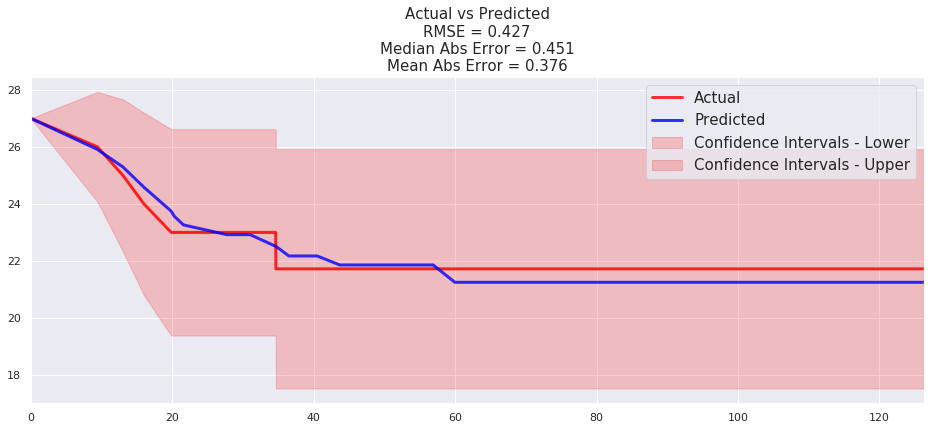

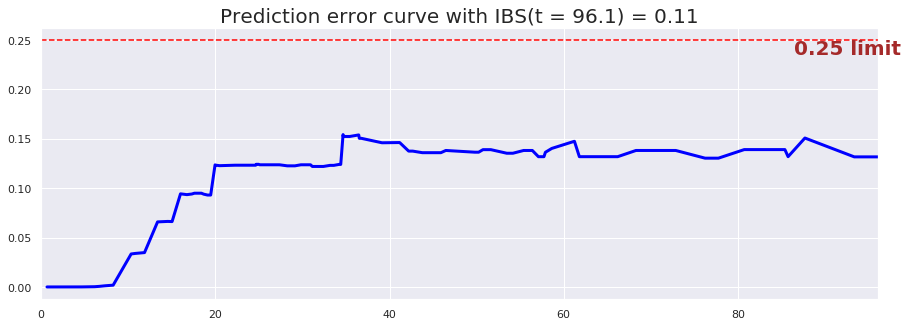

IBS: 0.11

 3 of kfold 5
xst3 3 C-index: 0.64


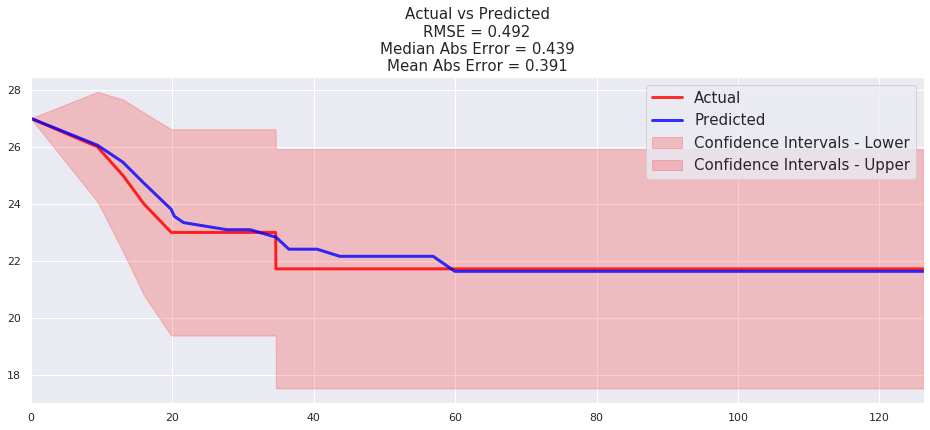

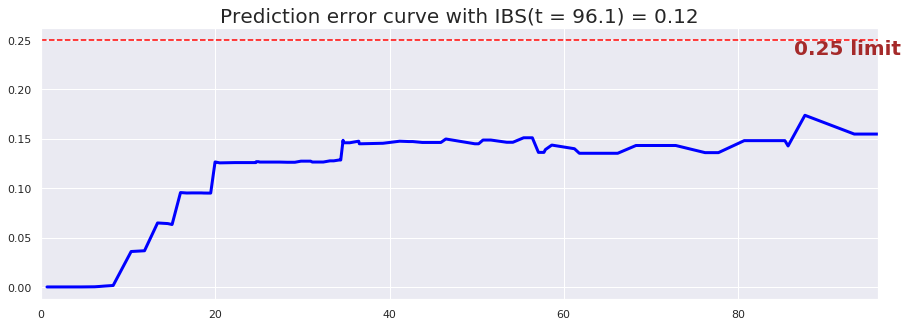

IBS: 0.12

 4 of kfold 5
C-index: 0.81


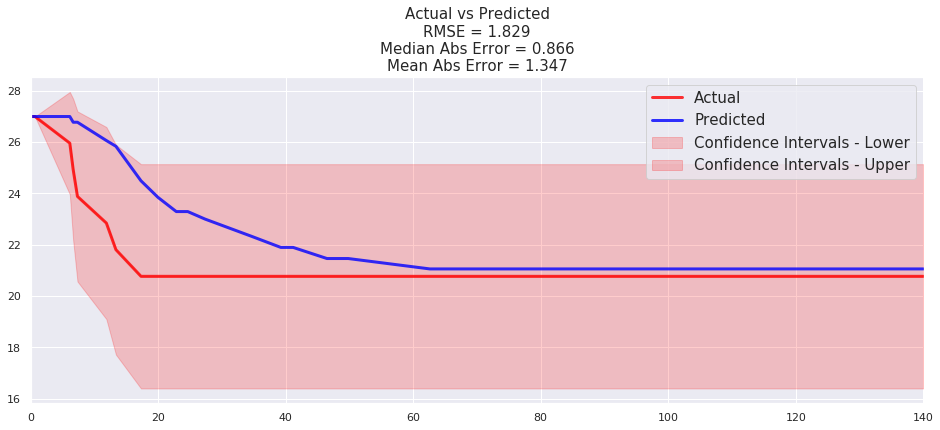

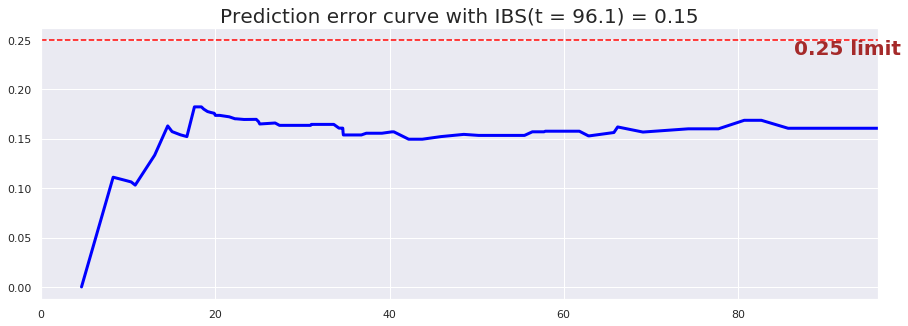

IBS: 0.15

 4 of kfold 5
xst2 2 C-index: 0.57


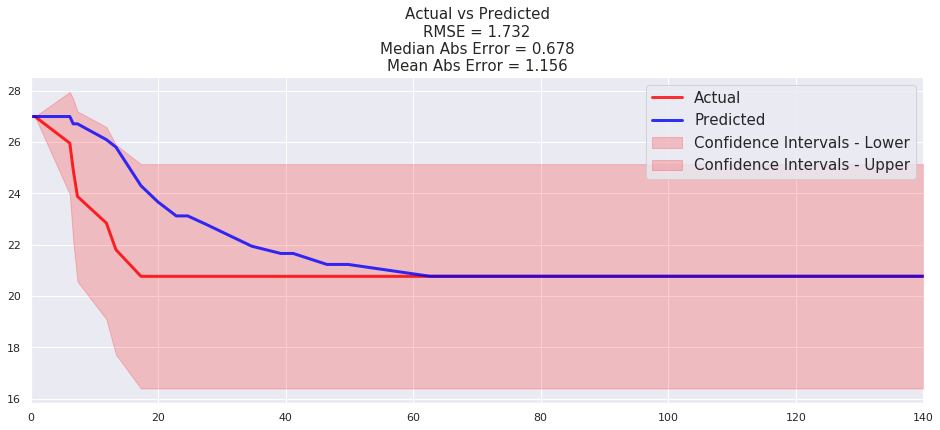

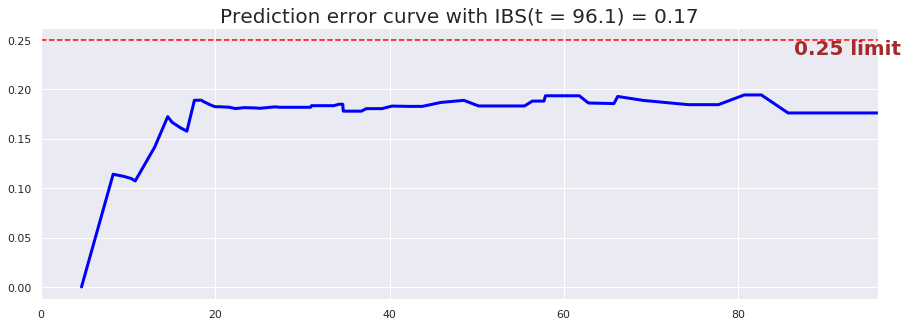

IBS: 0.17

 4 of kfold 5
xst3 3 C-index: 0.78


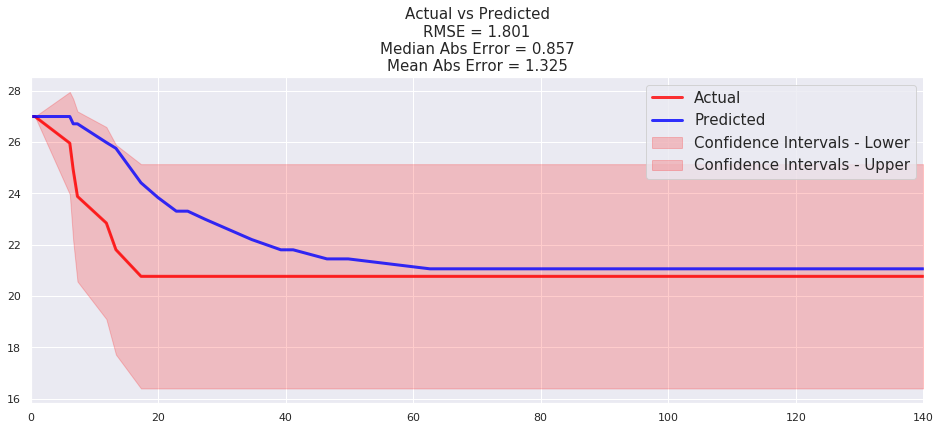

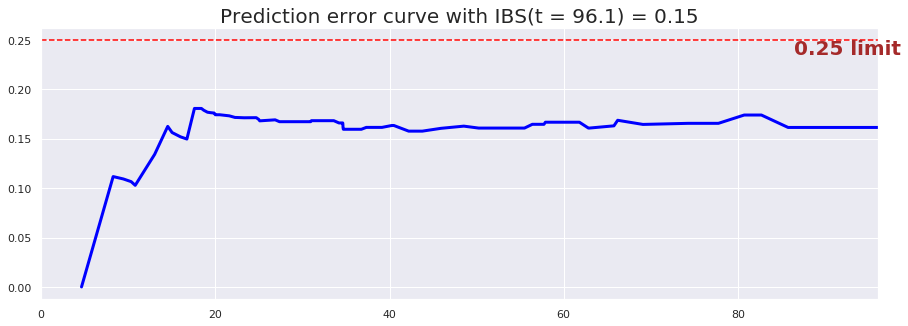

IBS: 0.15

 5 of kfold 5
C-index: 0.57


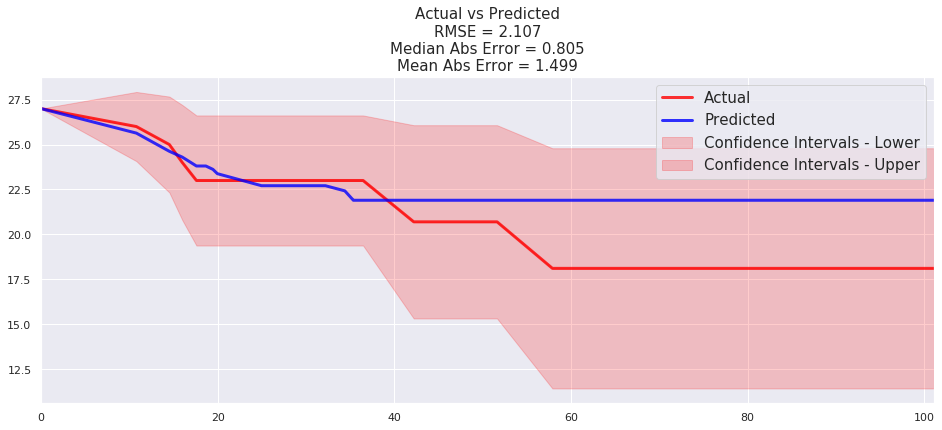

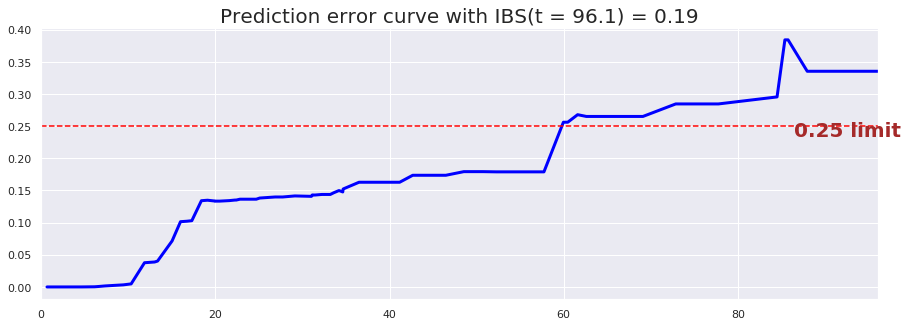

IBS: 0.19

 5 of kfold 5
xst2 2 C-index: 0.59


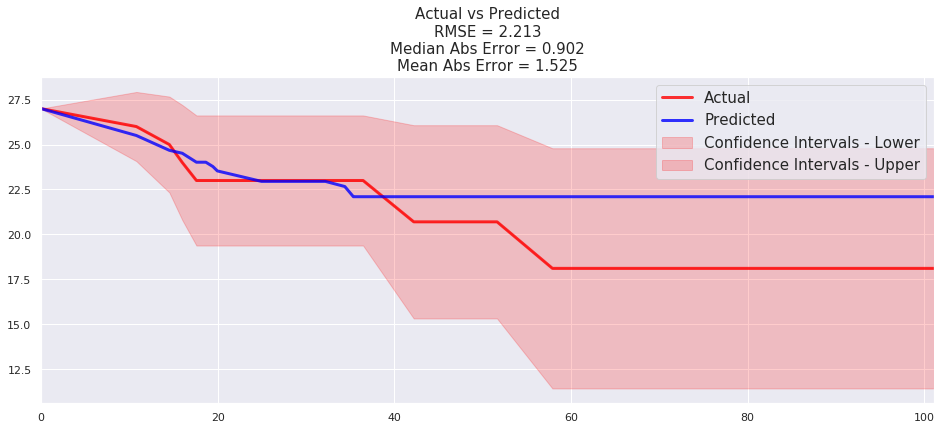

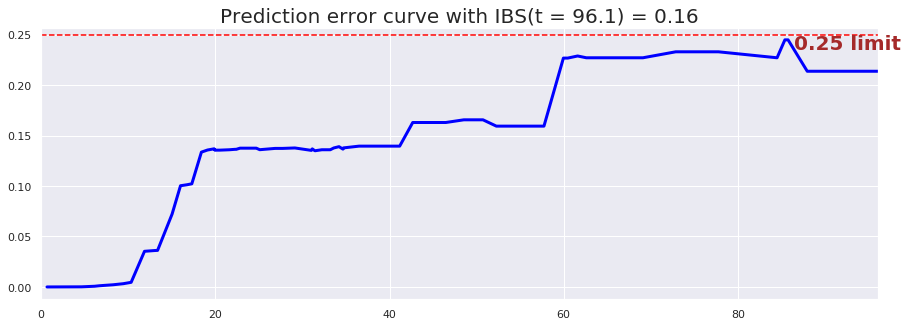

IBS: 0.16

 5 of kfold 5
xst3 3 C-index: 0.60


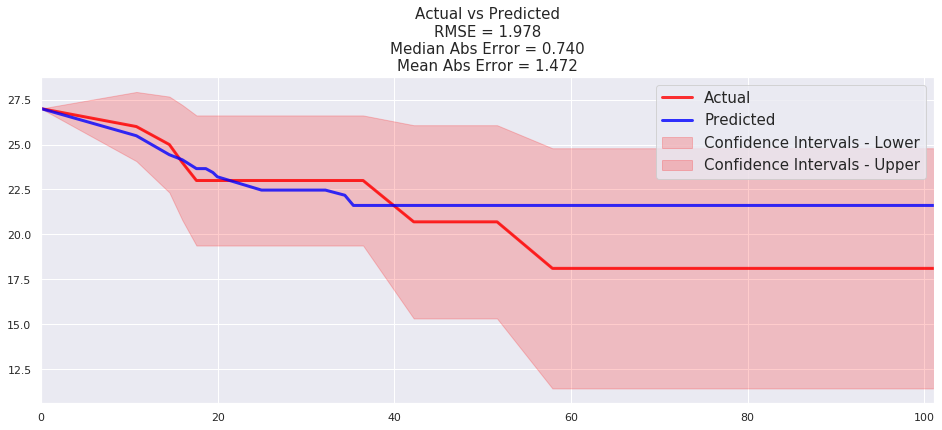

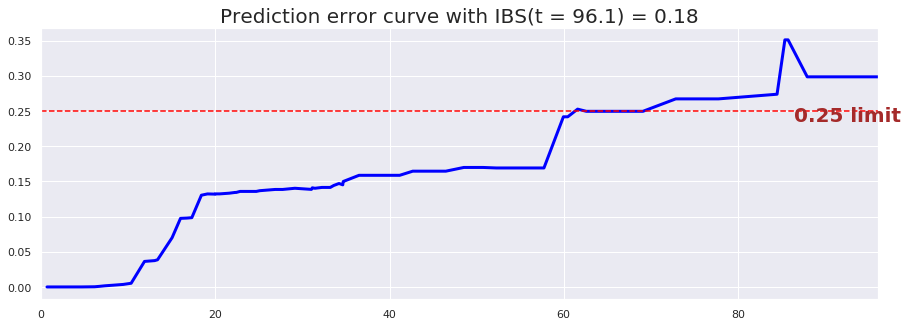

IBS: 0.18


In [30]:
#the random tree variables need to be fine tuned using loops because 
#the grid search CV is not compatible with the PySurvival package

from sklearn.model_selection import StratifiedKFold
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import compare_to_actual
from pysurvival.utils.display import integrated_brier_score
i=1
j=1
c=1
kf=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for train_index, test_index in kf.split(X,E):
    print('\n {} of kfold {}'.format(i,kf.n_splits)) 
    X1_train, X1_test=X.loc[train_index], X.loc[test_index]
    rad_features=['LBP94', 'LBP101', 'LBP106', 'LBP107', 'LBP108', 'LBP112', 'LBP116',
       'LBP118', 'LBP119', 'LBP120', 'FD27', 'FD51', 'FD54', 'ACM1_12']
    X_train, X_test=X1_train[rad_features], X1_test[rad_features]
    T_train, T_test=X1_train['time column'].values, X1_test['time column'].values
    E_train, E_test=E.loc[train_index].values, E.loc[test_index].values
    xst1 = RandomSurvivalForestModel(num_trees=400) 
    xst1.fit(X_train, T_train, E_train, max_features = 'sqrt', max_depth = 10,
        min_node_size = 5, num_threads = -1, 
        sample_size_pct = 0.63, importance_mode = 'normalized_permutation',
        seed = None, save_memory=False )
    c_index = concordance_index(xst1, X_test, T_test, E_test)
    print('C-index: {:.2f}'.format(c_index))
    results = compare_to_actual(xst1, X_test, T_test, E_test, is_at_risk = True,  figure_size=(16, 6), 
                                metrics = ['rmse', 'mean', 'median'])
    ibs = integrated_brier_score(xst1, X_test, T_test, E_test, t_max=100, figure_size=(15,5))
    print('IBS: {:.2f}'.format(ibs))
    i=i+1
    print('\n {} of kfold {}'.format(j,kf.n_splits))
    med_data=['BMI_0.0', 'BMI_1.0', 'BMI_2.0', 'Chemo ', 'Diabetes', 'Hist_0',
       'Hist_1', 'Hist_2', 'Hist_3', 'Hist_4', 'Node Status', 'adjuvalent',
       'age', 'race_0.0', 'race_1.0', 'race_2.0', 'race_3.0', 'race_4.0']
    X_train2, X_test2=X1_train[med_data], X1_test[med_data]
    xst2 = RandomSurvivalForestModel(num_trees=400) 
    xst2.fit(X_train2, T_train, E_train, max_features = 'sqrt', max_depth = 10,
        min_node_size = 5, num_threads = -1, 
        sample_size_pct = 0.63, importance_mode = 'normalized_permutation',
        seed = None, save_memory=False )
    c_index = concordance_index(xst2, X_test2, T_test, E_test)
    print('xst2 2 C-index: {:.2f}'.format(c_index))
    results = compare_to_actual(xst2, X_test2, T_test, E_test, is_at_risk = True,  figure_size=(16, 6), 
                                metrics = ['rmse', 'mean', 'median'])
    ibs = integrated_brier_score(xst2, X_test2, T_test, E_test, t_max=100, figure_size=(15,5))
    print('IBS: {:.2f}'.format(ibs))
    j=j+1
    print('\n {} of kfold {}'.format(c,kf.n_splits))
    med_data2=['LBP94', 'LBP101', 'LBP106', 'LBP107', 'LBP108', 'LBP112', 'LBP116',
       'LBP118', 'LBP119', 'LBP120', 'FD27', 'FD51', 'FD54', 'ACM1_12',
        'BMI_0.0', 'BMI_1.0', 'BMI_2.0', 'Chemo ', 'Diabetes', 'Hist_0',
       'Hist_1', 'Hist_2', 'Hist_3', 'Hist_4', 'Node Status', 'adjuvalent',
       'age', 'race_0.0', 'race_1.0', 'race_2.0', 'race_3.0', 'race_4.0']
    X_train3, X_test3=X1_train[med_data2], X1_test[med_data2]
    xst3 = RandomSurvivalForestModel(num_trees=400) 
    xst3.fit(X_train3, T_train, E_train, max_features = 'sqrt', max_depth = 10,
        min_node_size = 5, num_threads = -1, 
        sample_size_pct = 0.63, importance_mode = 'normalized_permutation',
        seed = None, save_memory=False )
    c_index = concordance_index(xst3, X_test3, T_test, E_test)
    print('xst3 3 C-index: {:.2f}'.format(c_index))
    results = compare_to_actual(xst3, X_test3, T_test, E_test, is_at_risk = True,  figure_size=(16, 6), 
                                metrics = ['rmse', 'mean', 'median'])
    ibs = integrated_brier_score(xst3, X_test3, T_test, E_test, t_max=100, figure_size=(15,5))
    print('IBS: {:.2f}'.format(ibs))
    c=c+1
   
    

### the importance table allows you to identify the main contributing features

In [32]:
xst3.variable_importance_table.head(20)
#the results indicate that we only had 3 variables which were important features

,feature,importance,pct_importance
0,FD51,7.255092,0.185359
1,FD54,3.614613,0.092349
2,LBP112,3.440372,0.087897
3,LBP101,3.440006,0.087888
4,age,3.228822,0.082493
5,LBP118,2.731892,0.069797
6,LBP108,2.465340,0.062987
7,LBP94,2.386087,0.060962
8,Hist_1,2.236560,0.057141
9,BMI_1.0,2.054683,0.052495


#### Below is an example on how to perform a grid search for the optimal RF parameters

In [33]:
num_tree=(10, 15, 20, 50, 100, 200, 400)
max_depth=(1, 3, 5, 7, 9, 10, 20, 40)
min_node=(1, 2,3, 5)


In [34]:
# this script searches the RF paramters listed in the cell 29
#prints out the average of 10 K Fold concordance
from sklearn.model_selection import StratifiedKFold
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.utils.metrics import concordance_index
from statistics import mean 

for a in num_tree:
    for b in max_depth:
        for c in min_node:
            cc=[]
            kf=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
            i=1
            for train_index, test_index in kf.split(X,E):
                X1_train, X1_test=X.loc[train_index], X.loc[test_index]
                X_train, X_test=X1_train[features2], X1_test[features2]
                T_train, T_test=X1_train['time column'].values, X1_test['time column'].values
                E_train, E_test=E.loc[train_index].values, E.loc[test_index].values
                xst = RandomSurvivalForestModel(num_trees=a) 
                xst.fit(X_train, T_train, E_train, max_features = 'sqrt', max_depth = b,
                min_node_size = c, num_threads = -1, 
                sample_size_pct = 0.63, importance_mode = 'normalized_permutation',
                seed = None, save_memory=False )
                from pysurvival.utils.metrics import concordance_index
                c_index = concordance_index(xst, X_test, T_test, E_test)
                cc.append(c_index)
                i=i+1
            print(a,b, c, "%.2g, %.2g, %.2g" % (mean(cc),  min(cc), max(cc)))
                 

10 1 1 0.59, 0.51, 0.69
10 1 2 0.67, 0.55, 0.73
10 1 3 0.66, 0.54, 0.78
10 1 5 0.64, 0.5, 0.72
10 3 1 0.61, 0.52, 0.79
10 3 2 0.66, 0.54, 0.74
10 3 3 0.62, 0.52, 0.77
10 3 5 0.65, 0.51, 0.71
10 5 1 0.64, 0.55, 0.74
10 5 2 0.64, 0.55, 0.72
10 5 3 0.62, 0.52, 0.71
10 5 5 0.7, 0.51, 0.8
10 7 1 0.62, 0.51, 0.78
10 7 2 0.65, 0.53, 0.88
10 7 3 0.66, 0.6, 0.73
10 7 5 0.65, 0.51, 0.81
10 9 1 0.69, 0.57, 0.78
10 9 2 0.65, 0.52, 0.73
10 9 3 0.65, 0.54, 0.76
10 9 5 0.61, 0.52, 0.68
10 10 1 0.62, 0.54, 0.7
10 10 2 0.66, 0.53, 0.75
10 10 3 0.63, 0.51, 0.79
10 10 5 0.6, 0.51, 0.72
10 20 1 0.67, 0.59, 0.76
10 20 2 0.61, 0.55, 0.72
10 20 3 0.69, 0.58, 0.82
10 20 5 0.62, 0.51, 0.74
10 40 1 0.65, 0.55, 0.72
10 40 2 0.64, 0.56, 0.76
10 40 3 0.65, 0.53, 0.79
10 40 5 0.67, 0.53, 0.77
15 1 1 0.64, 0.54, 0.8
15 1 2 0.66, 0.53, 0.77
15 1 3 0.61, 0.51, 0.76
15 1 5 0.71, 0.58, 0.77
15 3 1 0.66, 0.55, 0.75
15 3 2 0.68, 0.62, 0.75
15 3 3 0.72, 0.55, 0.88
15 3 5 0.68, 0.6, 0.81
15 5 1 0.66, 0.54, 0.89
15 5 2 0.67,


 1 of kfold 5
C-index: 0.67


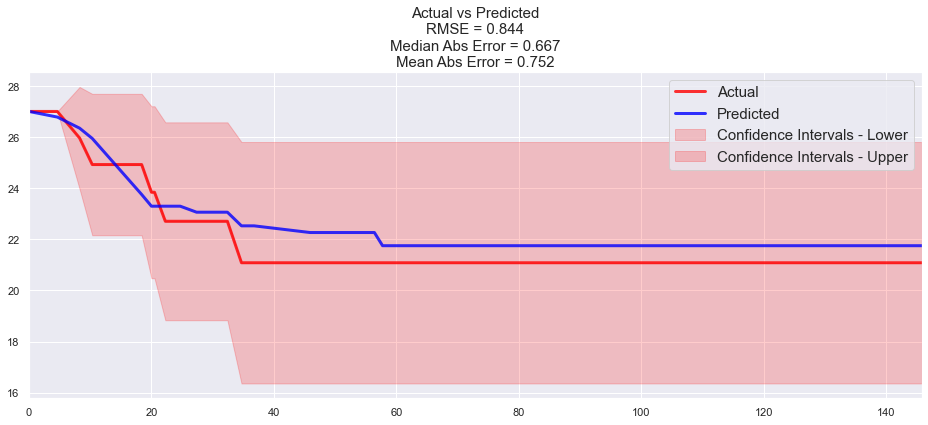

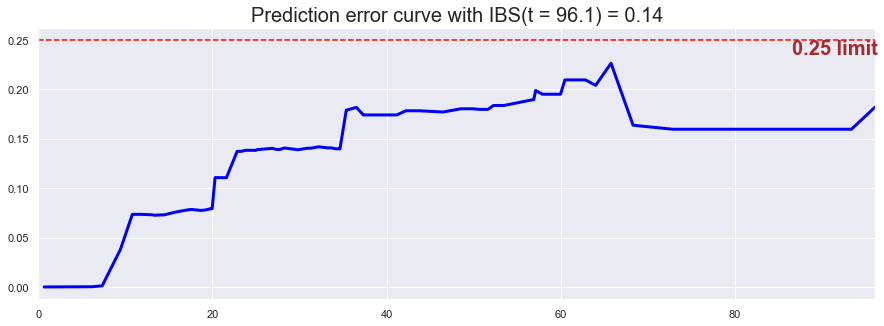

IBS: 0.14

 2 of kfold 5
C-index: 0.74


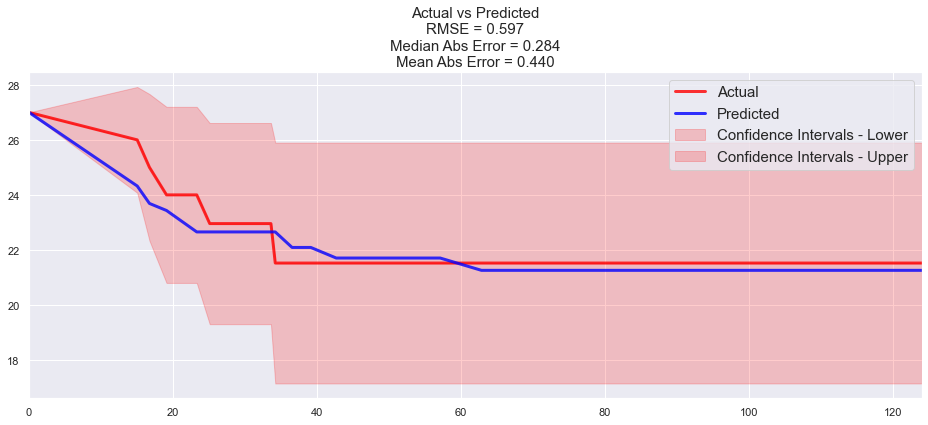

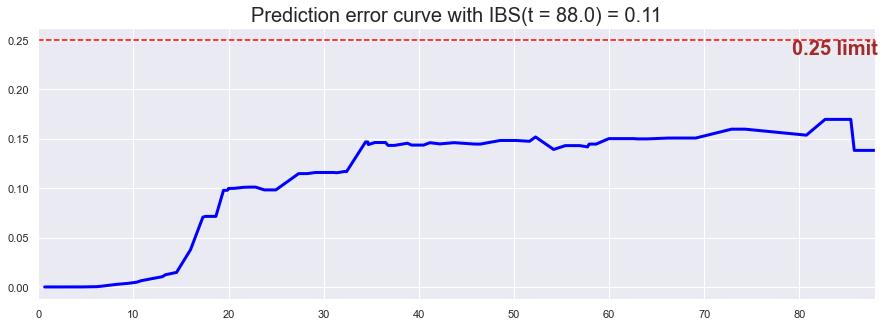

IBS: 0.11

 3 of kfold 5
C-index: 0.72


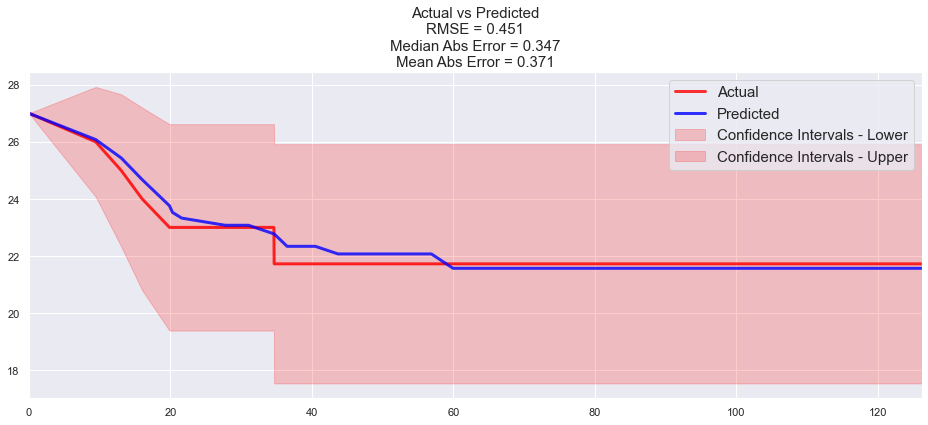

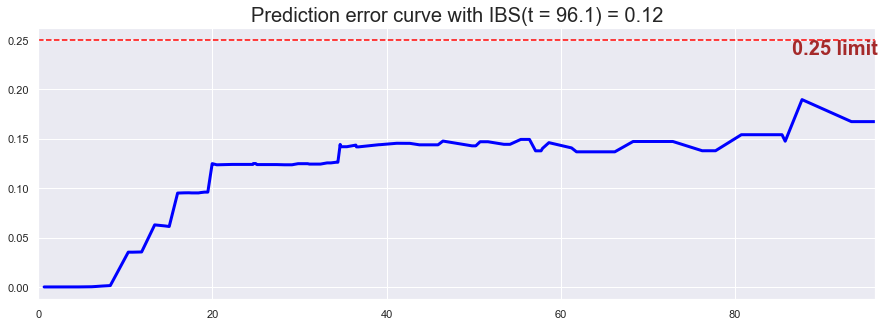

IBS: 0.12

 4 of kfold 5
C-index: 0.79


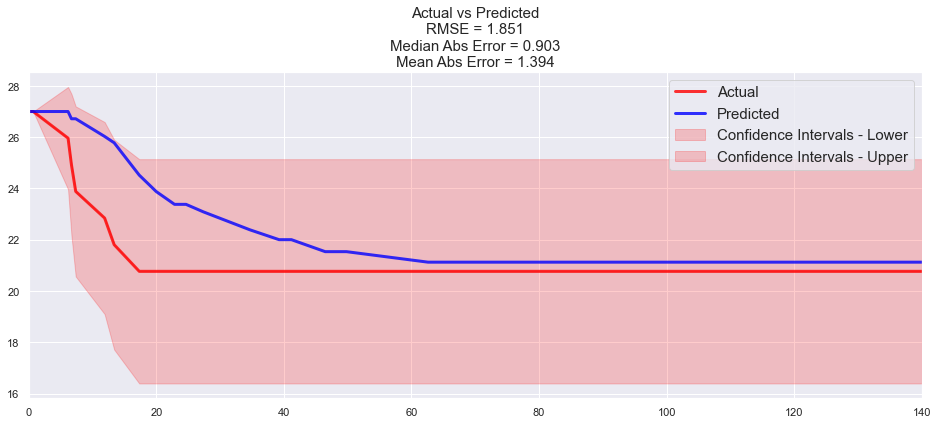

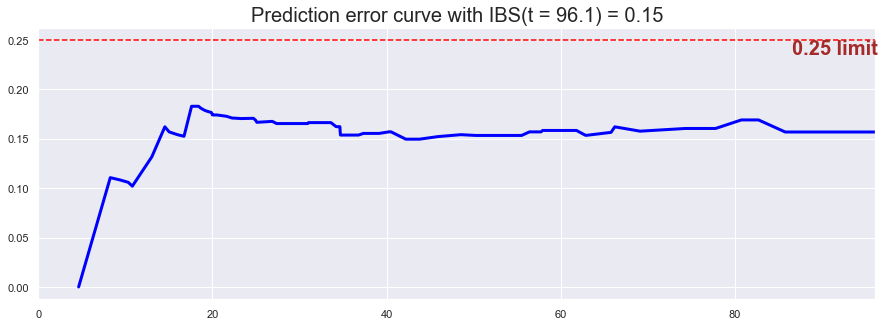

IBS: 0.15

 5 of kfold 5
C-index: 0.56


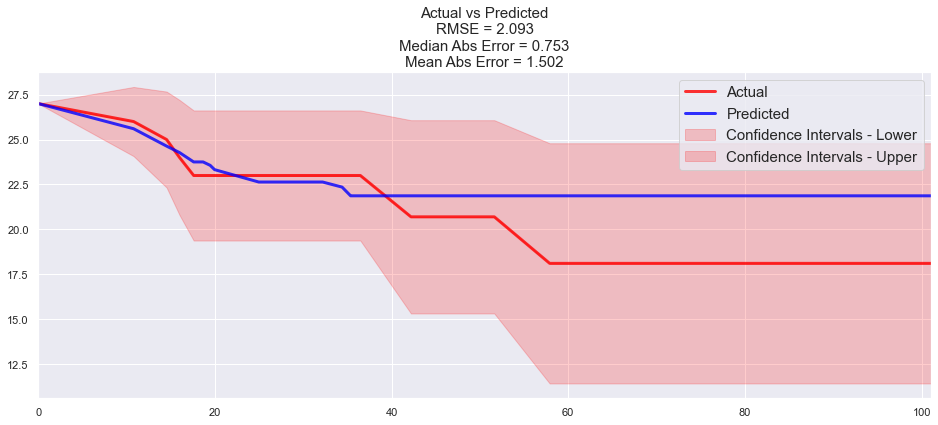

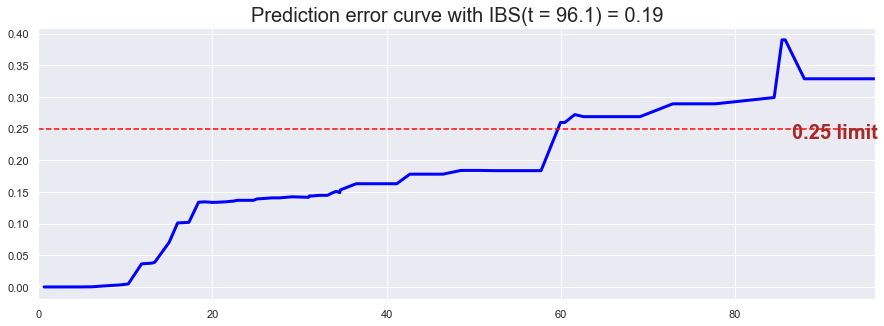

IBS: 0.19
0.6975851260264614 0.08652017681445058 0.1423381974987897 0.029216904278410432


In [35]:

import statistics
from sklearn.model_selection import StratifiedKFold
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import compare_to_actual
from pysurvival.utils.display import integrated_brier_score
i=1
j=1
c=1
CI = []
IBS = []
kf=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for train_index, test_index in kf.split(X,E):
    print('\n {} of kfold {}'.format(i,kf.n_splits)) 
    X1_train, X1_test=X.loc[train_index], X.loc[test_index]
    rad_features=['LBP94', 'LBP101', 'LBP106', 'LBP107', 'LBP108', 'LBP112', 'LBP116',
       'LBP118', 'LBP119', 'LBP120', 'FD27', 'FD51', 'FD54', 'ACM1_12']
    X_train, X_test=X1_train[rad_features], X1_test[rad_features]
    T_train, T_test=X1_train['time column'].values, X1_test['time column'].values
    E_train, E_test=E.loc[train_index].values, E.loc[test_index].values
    xst1 = RandomSurvivalForestModel(num_trees=400) 
    xst1.fit(X_train, T_train, E_train, max_features = 'sqrt', max_depth = 10,
        min_node_size = 5, num_threads = -1, 
        sample_size_pct = 0.63, importance_mode = 'normalized_permutation',
        seed = None, save_memory=False )
    c_index = concordance_index(xst1, X_test, T_test, E_test)
    print('C-index: {:.2f}'.format(c_index))
    results = compare_to_actual(xst1, X_test, T_test, E_test, is_at_risk = True,  figure_size=(16, 6), 
                                metrics = ['rmse', 'mean', 'median'])
    ibs = integrated_brier_score(xst1, X_test, T_test, E_test, t_max=100, figure_size=(15,5))
    print('IBS: {:.2f}'.format(ibs))
    CI.append(c_index)
    IBS.append(ibs)
    i=i+1
    
CIAvg = statistics.mean(CI)
CIStd = statistics.stdev(CI)
IBSAvg = statistics.mean(IBS)
IBSStd = statistics.stdev(IBS)

print(CIAvg, CIStd, IBSAvg, IBSStd)

In [36]:
X

,ACM1_12,BMI_0.0,BMI_1.0,BMI_2.0,Chemo,Diabetes,FD27,FD51,FD54,Hist_0,...,LBP94,Node Status,adjuvalent,age,race_0.0,race_1.0,race_2.0,race_3.0,race_4.0,time column
0,-0.072218,0,1,0,1.0,0.0,9.000000,0.079923,0.068974,0,...,0.008640,0.0,1.0,69,0,1,0,0,0,72.866667
1,-0.128768,1,0,0,1.0,0.0,3.333333,0.128958,0.112149,1,...,0.007668,0.0,1.0,71,0,0,1,0,0,57.733333
2,-0.044774,0,1,0,1.0,0.0,15.250000,0.056418,0.044223,1,...,0.021092,0.0,1.0,55,1,0,0,0,0,69.100000
3,-0.076017,1,0,0,1.0,0.0,15.750000,0.141440,0.121297,1,...,0.016198,0.0,1.0,61,1,0,0,0,0,39.233333
4,-0.071011,0,1,0,0.0,0.0,8.000000,0.157050,0.145854,0,...,0.009955,0.0,1.0,63,0,0,0,0,1,20.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,-0.051001,0,1,0,1.0,0.0,24.500000,0.087100,0.067616,0,...,0.022039,0.0,1.0,64,1,0,0,0,0,22.400000
131,-0.155972,1,0,0,0.0,1.0,25.888889,0.055196,0.037529,0,...,0.012268,0.0,1.0,73,0,0,1,0,0,8.266667
132,-0.041698,1,0,0,0.0,0.0,31.714286,0.100156,0.067450,1,...,0.015814,0.0,1.0,70,0,0,1,0,0,18.666667
133,-0.032100,0,1,0,1.0,1.0,59.888889,0.112976,0.065836,0,...,0.019432,0.0,1.0,68,1,0,0,0,0,20.300000
